In [8]:
import pickle
import numpy as np
import os
import platform
import matplotlib.pyplot as plt
import download
import data_utils
%matplotlib inline

In [9]:
class KNN(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.train_images = X
        self.train_labels = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.train_images.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.train_images), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.train_images.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.train_labels[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred

In [10]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [12]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./CIFARdata"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [13]:
cifar10_dir = './CIFARdata/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [14]:
categories=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'hourse', 'ship', 'truck']

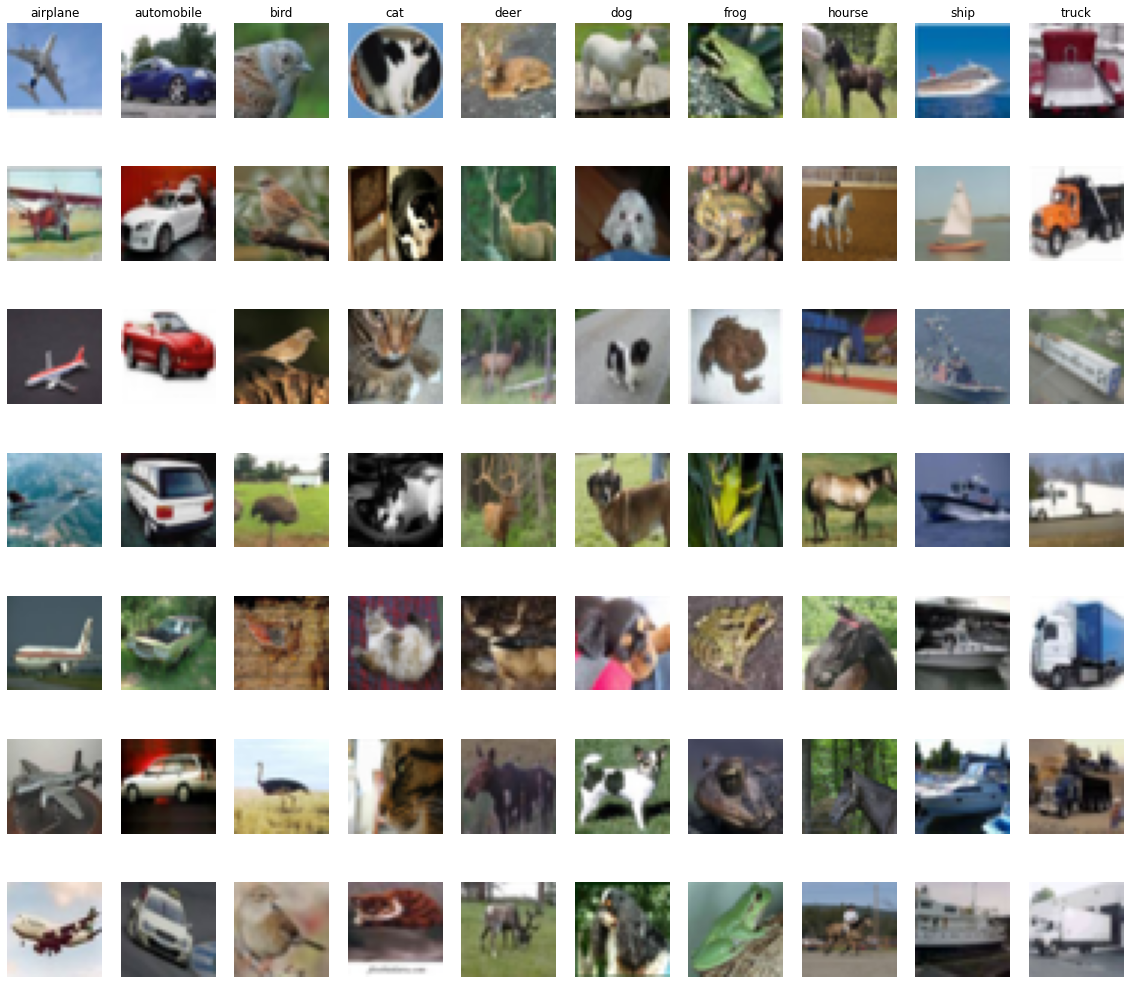

In [15]:
num_classes = len(categories)
samples_per_class = 7
plt.figure(figsize = (20, 18))
for y, cls in enumerate(categories):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [16]:
num_training = 1000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 100
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(1000, 3072) (100, 3072)


In [18]:
num_folds = 5
k_choices = [1, 6, 11, 14, 19, 25, 40, 55, 75, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNN()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k].append(accuracy)

k = 1, average accuracy = 0.476000
k = 6, average accuracy = 0.438000
k = 11, average accuracy = 0.442000
k = 14, average accuracy = 0.446000
k = 19, average accuracy = 0.464000
k = 25, average accuracy = 0.468000
k = 40, average accuracy = 0.450000
k = 55, average accuracy = 0.428000
k = 75, average accuracy = 0.436000
k = 100, average accuracy = 0.422000


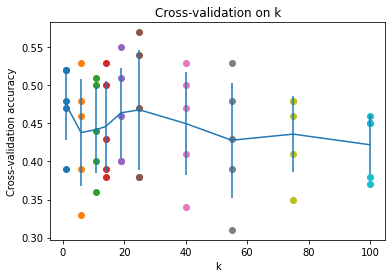

In [19]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    print('k = %d, average accuracy = %f' % (k, np.average(accuracies)))
    plt.scatter([k] * len(accuracies), accuracies)
  
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.rcParams['figure.figsize'] = [10,12]
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()